In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [4]:
data = yf.download("GOOGL" , start = "2019-01-01" , interval = '1d')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02 00:00:00-05:00,51.360001,53.039501,51.264000,52.734001,52.734001,31868000
2019-01-03 00:00:00-05:00,52.533501,53.313000,51.118500,51.273499,51.273499,41960000
2019-01-04 00:00:00-05:00,52.127998,54.000000,51.842999,53.903500,53.903500,46022000
2019-01-07 00:00:00-05:00,54.048500,54.134998,53.132000,53.796001,53.796001,47446000
2019-01-08 00:00:00-05:00,54.299999,54.667500,53.417500,54.268501,54.268501,35414000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 951 entries, 2019-01-02 00:00:00-05:00 to 2022-10-10 00:00:00-04:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       951 non-null    float64
 1   High       951 non-null    float64
 2   Low        951 non-null    float64
 3   Close      951 non-null    float64
 4   Adj Close  951 non-null    float64
 5   Volume     951 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 52.0 KB


In [6]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce')
data.isnull().sum().sum()

0

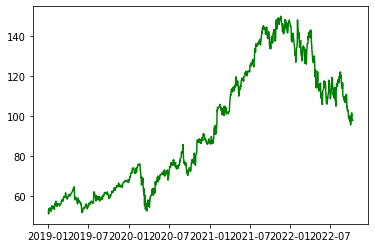

In [7]:
plt.plot(data.index, data['Close'], color='green', label='Close')
plt.show()

In [8]:
dataV1 = data.iloc[:,3:4]
dataV1 = dataV1.values

In [9]:
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler(feature_range=(0,1))
dataV1 = Scaler.fit_transform(dataV1)

In [10]:
feature_length = 100

In [11]:
# Function to create x and y data
def Create_Features_and_Targets(data, feature_length):
    X = list()
    Y = list()
    for i in range(len(data) - feature_length -1):
        X.append(data[i:(i + feature_length), 0])
        Y.append(data[i + feature_length, 0])
        
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

# calling the function
X_train,y_train= Create_Features_and_Targets(dataV1,feature_length)

In [12]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape, y_train.shape

((850, 100, 1), (850,))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM

In [14]:
# model
model = Sequential([
   LSTM(100,return_sequences=True,input_shape=(X_train.shape[1],1)),
   Dropout(0.3),
   LSTM(100, return_sequences = False),
   Dropout(0.3),
    
   Dense(1),
])
model.compile(optimizer='adam',loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Training the model
history = model.fit(
    X_train, 
    y_train, 
    epochs =50, 
    batch_size = 12, 
    verbose=1,
)

Epoch 1/50
71/71 [==============================] - 9s 14ms/step - loss: 0.0201
Epoch 2/50
71/71 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 3/50
71/71 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 4/50
71/71 [==============================] - 1s 13ms/step - loss: 0.0032
Epoch 5/50
71/71 [==============================] - 1s 13ms/step - loss: 0.0041
Epoch 6/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0045
Epoch 7/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0040
Epoch 8/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0046
Epoch 9/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 10/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0034
Epoch 11/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0031
Epoch 12/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0028
Epoch 13/50
71/71 [==================

In [16]:
testData = data.iloc[:,3:4] # Get 'Close' feature
y_real=testData.iloc[feature_length+1:,0:].values #Actual values
x_test = testData.iloc[:,0:].values # data to test
# normalizing the Data using Scaler.transform function
x_test = Scaler.transform(x_test)
x_test, y_test = Create_Features_and_Targets(x_test, feature_length)
# Making data 3 dimensional
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [17]:
y_pred = model.predict(x_test)
predicted_price = Scaler.inverse_transform(y_pred)

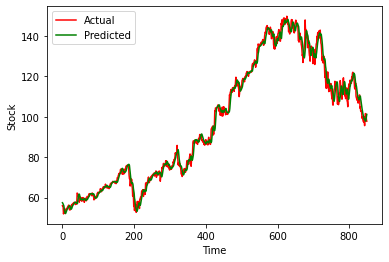

In [18]:
plt.plot(y_real, color = 'red', label = 'Actual')
plt.plot(predicted_price, color = 'green', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Stock')
plt.legend()
plt.show()

In [19]:
new_df = pd.DataFrame(y_real, columns=["y_real"])

In [20]:
new_df.head()

,y_real
0,55.997002
1,56.070499
2,55.325001
3,51.937000
4,52.724499


In [21]:
new_df['predicted_price'] = predicted_price

In [22]:
new_df.head()

,y_real,predicted_price
0,55.997002,57.478767
1,56.070499,57.241665
2,55.325001,56.819023
3,51.937000,56.438168
4,52.724499,55.972408


In [23]:
fig = px.line(new_df,
              y=['y_real','predicted_price'],
              title='custom tick labels')
fig